In [13]:
from cStringIO import StringIO          #     Used to save and display the image in the IPython notebook 
                                        #      as its generated, used only in showarray()

import numpy as np                      #     Used to do all the matrix math, with the exception of the zoom

import scipy.ndimage as nd              #     Used for nd.zoom on the images (octaves) in deepdream()
import PIL.Image                        #     Used to load images from file, and to save manipulated images back to 
                                        #     files

from IPython.display import clear_output, Image, display

In [4]:
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']

    # rolling the axis switches the structure of the matrix – 
    # We go from having Red, Green, and Blue values for each x and y coordinate
    # to having a 3 channels of red, green and blue images.

# Now this function above is a doozie. Don't let its shortness deceive you, it's doing a lot.
# net.transformer.mean['data'] is our image mean we discussed above. it's being subtracted from
# np.float32(np.rollaxis(img, 2)[::-1]). This function warrants a discussion about numpy. I'll 
# dive deeper into it below. [He discusses this with examples in the article - RS]

def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

# This function does the reverse of preprocess, and I'll go over how it works below too. But 
# both these functions warrant talking about how they work.

def preprocesswithoutmean(img):
    return np.float32(np.rollaxis(img, 2)[::-1]) # see preprocess() for explanation

def deprocesswithoutmean(img):
    return np.dstack(img[::-1])

In [7]:
def objective_L2(dst):          # Our training objective. Google has since released a way to load
    dst.diff[:] = dst.data      # arbitrary objectives from other images. [Explanation of this in the article - RS]


def make_step(net, step_size=1.5, end='inception_4b/3x3',      
              jitter=32, clip=True, objective=objective_L2):    #  This end layer differs from the original Google deepdream
    '''Basic gradient ascent step.'''                           #  in order to match the places dataset

    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    dst = net.blobs[end]    # destination is the end layer specified above

                            # The end layer is the name of the layer or blob (as some call it) at which to stop
                            # For explanation of the layer structure of the model, check out
                            # http://overstruck.com/how-to-customize-googles-deepdream/

                            # Step-by-step illustration of the layers:
                            # http://hideepdreams.com/post/123387228638/testing-layers-of-googles-deepdreams

    # Jitter is well-explained in the article with illustrative examples. Jitter just
    # shifts the image over a few pixels with some degree of randomness, introducing 
    # randomness to gradient descent. 

    ox, oy = np.random.randint(-jitter, jitter+1, 2)            # generate random jitter
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) # apply jitter shift
            
    # Forward and backward passes: http://caffe.berkeleyvision.org/tutorial/forward_backward.html

    net.forward(end=end)     # This is how the network computes, make sure we stop on the chosen neural layer
    objective(dst)           # specify the optimization objective
    net.backward(start=end)  # Do backwards propagation, so we can compute how off we were 
    g = src.diff[0]          
    
    # apply normalized ascent step to the input image
    src.data[:] += step_size/np.abs(g).mean() * g # get closer to our target data

    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image jitter
            
    if clip:                                              # If clipping is enabled
        bias = net.transformer.mean['data']               # Subtract our image mean
        src.data[:] = np.clip(src.data, -bias, 255-bias)  # clip our matrix to the values


In [8]:
def deepdream(net, base_img, iter_n=10, octave_n=4, octave_scale=1.4, 
              end='inception_4b/3x3', clip=True, **step_params):
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]   # So, the octaves is an array of images, initialized 
                                            # with the original image transformed into caffe's format
    for i in xrange(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    
    # Okay, so this creates smaller versions of the images, and appends them to the array of images.
    # One image for each octave.
    
    src = net.blobs['data']             # Again, copy the original image.
    detail = np.zeros_like(octaves[-1]) # Allocate image for network-produced details.
                                        # This creates a matrix shaped like our image, 
                                        # but fills it with zeroes.

    for octave, octave_base in enumerate(octaves[::-1]): # Iterate over the reversed list of images (smallest first)
        h, w = octave_base.shape[-2:]                    # Take the width and height of the current image
        if octave > 0:  # If it's not the smallest octave
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1) # Zoom in on the image detail, interpolate

        src.reshape(1,3,h,w) # resize the network's input image size
        src.data[0] = octave_base+detail # Add the changed details to the image
        for i in xrange(iter_n):  # number of step iterations, specified above
            make_step(net, end=end, clip=clip, **step_params) # call the function that actually runs the network
            
            # visualization
            vis = deprocess(net, src.data[0]) # Convert back to jpg format
            if not clip: # adjust image contrast if clipping is disabled
                vis = vis*(255.0/np.percentile(vis, 99.98))
            showarray(vis)
            print octave, i, end, vis.shape
            clear_output(wait=True) # clear previous input
            
        # extract details produced on the current octave
        detail = src.data[0]-octave_base
    # returning the resulting image
    return deprocess(net, src.data[0])

In [9]:
img = np.float32(PIL.Image.open('jpg/overbridge.jpg'))

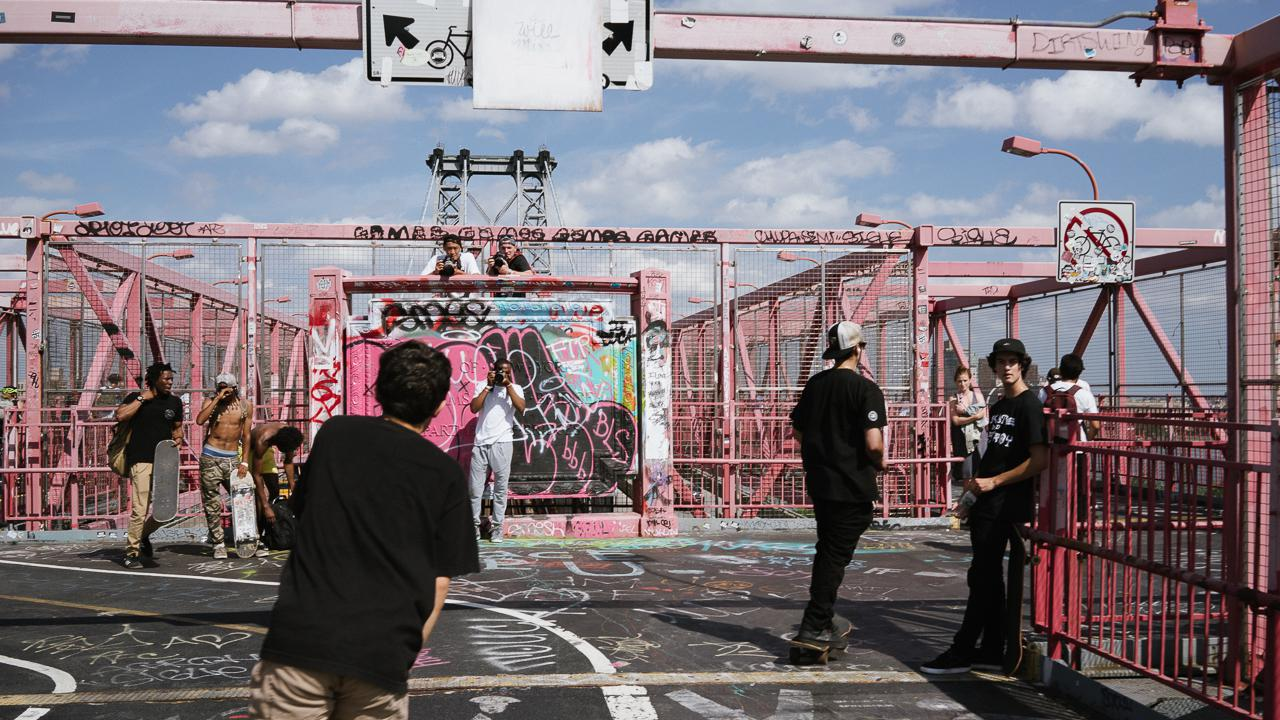

In [18]:
def showarray(a, fmt='jpeg'):           #     IPython helper used to show images in progress
    
    a = np.uint8(np.clip(a, 0, 255))    #     Convert and clip our matrix into the jpeg constraints (0-255 values
                                        #     for Red, Green, Blue)
        
    f = StringIO()                      #     String file handler; I'm outputting differently due to Ipython issues
                                        #     on lab.cs.swarthmore.edu

    PIL.Image.fromarray(a).save(f, fmt) #     Rather than saving to a file each time, save to our string handler
    display(Image(data=f.getvalue()))   #     Display the image in our notebook, using the IPython.display, and 
                                        #     IPython.Image helpers.

        
showarray(img)

In [19]:
_ = deepdream(net, img, end='inception_4b/3x3')

NameError: name 'net' is not defined